
Primer entregable del curso:

**TÉCNICAS AVANZADAS DE DATA MINING Y SISTEMAS INTELIGENTES (INF659-A651) **

***Integrantes:*** 

*   Erasmo Gomez
*   John Miller

***Tema:***

Aplicación de Seq2Seq en Neural Machine Translation.

***Tema Futuro:***

Aplicación de NMT para lenguas minoritarias.

**Fuente: **

[GitHub TensorFlow](https://github.com/tensorflow/nmt)

***Notebook:***

[NB Ejecutado](https://colab.research.google.com/drive/12FH_FQOQmhZ3s22kG5kxAvlvRehxiY1g)



In [2]:
#Librerias necesarias

from __future__ import absolute_import, division, print_function

import tensorflow as tf

tf.enable_eager_execution() #Para facilitar los outputs

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import unicodedata
import re
import numpy as np
import os
import time

import random

print(tf.__version__)

1.12.0


## Preparando el Dataset

Las oraciones descargadas estan en el siguiente formato:

<img src="https://www.wolframcloud.com/objects/46d1e9b7-9da7-4fc9-b491-63f549b56cc6">


1. Se agrega tokens al inicio y final de las oraciones.
2. Se remueven caracteres especiales.
3. Se crean diccionarios indexados.
4. Se realiza un padding para arreglar los batches y que tengan el mismo tamaño.

In [3]:
# Descargando el archivo, para esta prubea de Español a Ingles
path_to_zip = tf.keras.utils.get_file(
    'spa-eng.zip', origin='http://download.tensorflow.org/data/spa-eng.zip', 
    extract=True)

path_to_file = os.path.dirname(path_to_zip)+"/spa-eng/spa.txt"

In [4]:
path_to_file = "./shi_esp_all.txt"

In [5]:
def unicode_to_ascii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn')


def preprocess_sentence(w):
    w = unicode_to_ascii(w.lower().strip())
    
    # separando las palabras y las puntuaciones, para que puedan ser consideradas como tokens.
    w = re.sub(r"([?.!,¿])", r" \1 ", w)
    w = re.sub(r'[" "]+', " ", w)
    
    # eliminando todo lo que no sea letras y signos permitidos.
    w = re.sub(r"[^a-zA-Z?.!,¿]+", " ", w)
    
    w = w.rstrip().strip()
    
    # agregando los tokens de comienzo y fin en las oraciones.
    w = '<start> ' + w + ' <end>'
    return w

In [6]:
def create_dataset(path, num_examples):
    lines = open(path, encoding='UTF-8').read().strip().split('\n')
    
    word_pairs = [[preprocess_sentence(w) for w in l.split('\t')]  for l in lines[:num_examples]]
    # crea el dataset separando las palabras en español e ingles en un par.
    return word_pairs

In [7]:
# creando el diccionario con los indices para las palabras.
class LanguageIndex():
    def __init__(self, lang):
        self.lang = lang
        self.word2idx = {}
        self.idx2word = {}
        self.vocab = set()
        
        self.create_index()
    
    def create_index(self):
        for phrase in self.lang:
            self.vocab.update(phrase.split(' '))
    
        self.vocab = sorted(self.vocab)
        self.word2idx['<pad>'] = 0
        
        for index, word in enumerate(self.vocab):
            self.word2idx[word] = index + 1
    
        for word, index in self.word2idx.items():
            self.idx2word[index] = word

In [8]:
def max_length(tensor):
    return max(len(t) for t in tensor)


def load_dataset(path, num_examples):
  
    pairs = create_dataset(path, num_examples)
  
    inp_lang = LanguageIndex(sp for en, sp in pairs)
    targ_lang = LanguageIndex(en for en, sp in pairs)
    
    # Oraciones en Español.
    input_tensor = [[inp_lang.word2idx[s] for s in sp.split(' ')] for en, sp in pairs]
    
    # Oraciones en Inglés.
    target_tensor = [[targ_lang.word2idx[s] for s in en.split(' ')] for en, sp in pairs]
    
    # Se calcula el mayor tamaño de oración y se establece como base para el padding.
    max_length_inp, max_length_tar = max_length(input_tensor), max_length(target_tensor)
    
    # Aplicando el padding.
    input_tensor = tf.keras.preprocessing.sequence.pad_sequences(input_tensor, 
                                                                 maxlen=max_length_inp,
                                                                 padding='post')
    
    target_tensor = tf.keras.preprocessing.sequence.pad_sequences(target_tensor, 
                                                                  maxlen=max_length_tar, 
                                                                  padding='post')
    
    return input_tensor, target_tensor, inp_lang, targ_lang, max_length_inp, max_length_tar

In [11]:
# Trabajando con solo 40K datos para que no demore mucho.
num_examples = 20000
input_tensor, target_tensor, inp_lang, targ_lang, max_length_inp, max_length_targ = load_dataset(path_to_file, num_examples)

In [12]:
# Split de 80 y 20
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.2)

len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val)

(16000, 16000, 4000, 4000)

### Creando el Dataset de tensor flow

In [23]:
BUFFER_SIZE = len(input_tensor_train)
BUFFER_SIZE_val = len(input_tensor_val)
BATCH_SIZE = 64
N_BATCH = BUFFER_SIZE//BATCH_SIZE
N_BATCH_val = BUFFER_SIZE_val//BATCH_SIZE
embedding_dim = 128
units = 768
vocab_inp_size = len(inp_lang.word2idx)
vocab_tar_size = len(targ_lang.word2idx)

dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

datasetval = tf.data.Dataset.from_tensor_slices((input_tensor_val, target_tensor_val)).shuffle(BUFFER_SIZE_val)
datasetval = datasetval.batch(BATCH_SIZE, drop_remainder=True)

## Modelo de Encoder y Decoder



*   Funcion para definir una capa de GRU (gated recurrent units)  
*   Encoder class - extension de Keras Model con argumento de Encoder  
*   Decoder class - extension de Keras Model con argumento de Decoder  



In [14]:
def gru(units):
    if tf.test.is_gpu_available():
        return tf.keras.layers.CuDNNGRU(units, 
                                    return_sequences=True, 
                                    return_state=True, 
                                    recurrent_initializer='glorot_uniform')
    else:
        return tf.keras.layers.GRU(units, 
                               return_sequences=True, 
                               return_state=True, 
                               recurrent_activation='sigmoid', 
                               recurrent_initializer='glorot_uniform')

### Encoder


1.   Init estructura  
  - batch_sz, #units
  - capa de embedding (lengua src)
  - capa de GRU
2.   Init estado  
  - #units por batch_sz  
3.  Proceso por cada palabra  
  - Recoger embedding  
  - Procesar con capa GRU  



In [15]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
        super(Encoder, self).__init__()
        self.batch_sz = batch_sz
        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = gru(self.enc_units)
        
    def call(self, x, hidden):
        x = self.embedding(x)
        output, state = self.gru(x, initial_state = hidden)        
        return output, state
    
    def initialize_hidden_state(self):
        return tf.zeros((self.batch_sz, self.enc_units))

### Decoder  


1.   Init estructura  
  - batch_sz, #units
  - capa de embedding (lengua target)  
  - capa de GRU  
  - capa de softmax para elegir palabra de target  
  - mecanismo de atención  
2.   Init estado  
  - #units por batch_sz
3.  Proceso por cada palabra
  - Calcular pesos de atención
  - Calcular contexto tomando en cuenta atención
  - Recoger embedding  
  - Concatenar embedding y contexto  
  - Procesar con capa GRU  
  - Proyectionar 'output' de decoder al capa Dense



In [16]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
        super(Decoder, self).__init__()
        self.batch_sz = batch_sz
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = gru(self.dec_units)
        self.fc = tf.keras.layers.Dense(vocab_size)
        
        self.W1 = tf.keras.layers.Dense(self.dec_units)
        self.W2 = tf.keras.layers.Dense(self.dec_units)
        self.V = tf.keras.layers.Dense(1)
        
    def call(self, x, hidden, enc_output):
        
        hidden_with_time_axis = tf.expand_dims(hidden, 1)
        
        score = tf.nn.tanh(self.W1(enc_output) + self.W2(hidden_with_time_axis))
        
        # Se calculan los pesos de atención.
        attention_weights = tf.nn.softmax(self.V(score), axis=1)
        
        context_vector = attention_weights * enc_output
        context_vector = tf.reduce_sum(context_vector, axis=1)
        
        x = self.embedding(x)
        
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)
        
        output, state = self.gru(x)
        # Preservamos el estado de la GRU
        output = tf.reshape(output, (-1, output.shape[2]))
        
        x = self.fc(output)
        
        return x, state, attention_weights
        
    def initialize_hidden_state(self):
        return tf.zeros((self.batch_sz, self.dec_units))

In [17]:
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

## Definición de la optimización  


*   Cross entropy loss  
*   target=='pad' => mask==0  (No loss)  



In [18]:
optimizer = tf.train.AdamOptimizer()


def loss_function(real, pred):
    mask = 1 - np.equal(real, 0)
    loss_ = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=real, logits=pred) * mask
    return tf.reduce_mean(loss_)


## Checkpoints

In [19]:
checkpoint_dir = './training_checkpoints_ship/'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

## Entrenamiento

1. Pasar el input al encoder para obtener el hidden y el output del encoder.
2. Pasar al decoder los resultados del paso anterior, asi como el input del decoder.
3. El decoder retorna la predicción.
4. El decoder hidden es pasado denuevo al modelo para calcular la perdida.
5. Se aplica "Teacher forcing" para ayudar al input del decoder en la siguiente iteración.
6. Con "Teacher forcing" se pasa la palabra target como siguiente input al decoder.
7. Se calcula las gradientes y se aplica el optimizador y luego usar backpropagation.

In [ ]:
EPOCHS = 10
trn_loss_arr1 = {}
val_loss_arr1 = {}

for epoch in range(EPOCHS):
    start = time.time()
    
    hidden = encoder.initialize_hidden_state()
    total_loss = 0
    total_val_loss = 0

    
    for (batch, (inp, targ)) in enumerate(dataset):
        loss = 0
        print('N Batch : {:d}'.format(batch))
        with tf.GradientTape() as tape:
            enc_output, enc_hidden = encoder(inp, hidden)
            
            dec_hidden = enc_hidden
            
            dec_input = tf.expand_dims([targ_lang.word2idx['<start>']] * BATCH_SIZE, 1)       
            #print('ggzone {:d}'.format(targ.shape[1]))
            # Teacher forcing - alimentar con el target al siguiente input.
            for t in range(1, targ.shape[1]):
                predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)
                loss += loss_function(targ[:, t], predictions)
                use_tf = random.random();
                if use_tf < 0.5:
                    dec_input = tf.expand_dims(targ[:, t], 1)
                else:
                    dec_input = tf.expand_dims(tf.argmax(predictions, axis=1), 1)
                
        batch_loss = (loss / int(targ.shape[1]))

        total_loss += batch_loss

        variables = encoder.variables + decoder.variables

        gradients = tape.gradient(loss, variables)

        optimizer.apply_gradients(zip(gradients, variables))
            
        if batch % 100 == 0:
            print('Epoch {} Batch {} Train Loss {:.4f}'.format(epoch + 1,
                                                         batch,
                                                         batch_loss.numpy()))
    
    hidden1 = encoder.initialize_hidden_state()
    for (batch1, (inp1, targ1)) in enumerate(datasetval):
        loss_val = 0
        
        enc_output1, enc_hidden1 = encoder(inp1, hidden1)
            
        dec_hidden1 = enc_hidden1
            
        dec_input1 = tf.expand_dims([targ_lang.word2idx['<start>']] * BATCH_SIZE, 1)       
            
        for t1 in range(1, targ1.shape[1]):
            predictions1, dec_hidden1, _ = decoder(dec_input1, dec_hidden1, enc_output1)
                
            loss_val += loss_function(targ1[:, t1], predictions1)

            dec_input1 = tf.expand_dims(tf.argmax(predictions1, axis=1), 1)
        
        batch_loss_val = (loss_val / int(targ1.shape[1]))
        
        total_val_loss += batch_loss_val
                                       
        if batch1 % 10 == 0:
            print('Epoch {} Batch {} Val Loss {:.4f}'.format(epoch + 1,
                                                         batch1,
                                                         batch_loss_val.numpy()))                     
        
    trn_loss_arr1[epoch] = total_loss
    val_loss_arr1[epoch] = total_val_loss
    
    # Guardando Checkpoints
    if (epoch + 1) % 5 == 0:
        checkpoint.save(file_prefix = checkpoint_prefix)
    
    print('Epoch {} Train Loss x Epoch {:.4f}'.format(epoch + 1,total_loss / N_BATCH))
    print('Epoch {} Val Loss x Epoch {:.4f}'.format(epoch + 1, total_val_loss / N_BATCH_val))
    print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

N Batch : 0
Epoch 1 Batch 0 Train Loss 1.2616
N Batch : 1
N Batch : 2
N Batch : 3
N Batch : 4
N Batch : 5
N Batch : 6
N Batch : 7
N Batch : 8
N Batch : 9
N Batch : 10
N Batch : 11
N Batch : 12
N Batch : 13
N Batch : 14
N Batch : 15
N Batch : 16
N Batch : 17
N Batch : 18
N Batch : 19
N Batch : 20
N Batch : 21
N Batch : 22
N Batch : 23
N Batch : 24
N Batch : 25
N Batch : 26
N Batch : 27
N Batch : 28
N Batch : 29
N Batch : 30
N Batch : 31
N Batch : 32
N Batch : 33
N Batch : 34
N Batch : 35
N Batch : 36
N Batch : 37
N Batch : 38
N Batch : 39
N Batch : 40
N Batch : 41
N Batch : 42
N Batch : 43
N Batch : 44
N Batch : 45
N Batch : 46
N Batch : 47
N Batch : 48
N Batch : 49
N Batch : 50
N Batch : 51
N Batch : 52
N Batch : 53
N Batch : 54
N Batch : 55
N Batch : 56
N Batch : 57
N Batch : 58
N Batch : 59
N Batch : 60
N Batch : 61
N Batch : 62
N Batch : 63
N Batch : 64
N Batch : 65
N Batch : 66
N Batch : 67
N Batch : 68
N Batch : 69
N Batch : 70
N Batch : 71
N Batch : 72
N Batch : 73
N Batch : 74
N

In [20]:
def show_results(trn,val):
    trn_loss = (np.array(list(trn.values()), dtype="float32")/N_BATCH).tolist()
    val_loss = (np.array(list(val.values()), dtype="float32")/N_BATCH_val).tolist()
    fig, ax1 = plt.subplots(1, 1, figsize=(14,4))
    ax1.plot(trn_loss, label='train')
    ax1.plot(val_loss, label='validation')
    ax1.set_xlabel('epoch'); 
    ax1.set_ylabel('loss')
    ax1.set_title("", size=14)
    ax1.legend()

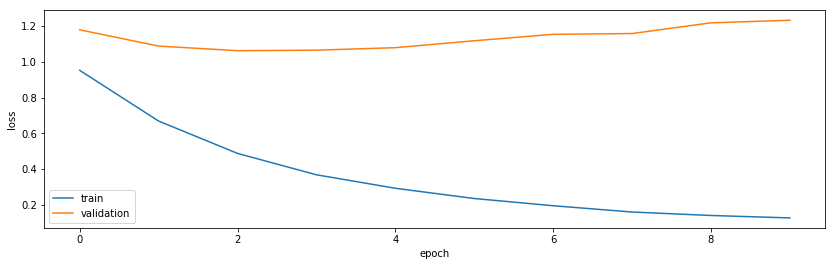

In [21]:
show_results(trn_loss_arr1,val_loss_arr1)

## Traducción

* La evaluacioón es muy similar al entrenamiento. El input del decoder es la prediccion previa, a diferencia del entrenamiento no usamos Teaching Forcing aquí. 
* Se para de predecir cuando se recibe el "end token".
* Tambien se guardan los pesos.
* La salida del encoder es calculado una vez por input.

In [22]:
def evaluate(sentence, encoder, decoder, inp_lang, targ_lang, max_length_inp, max_length_targ):
    attention_plot = np.zeros((max_length_targ, max_length_inp))
    
    sentence = preprocess_sentence(sentence)

    inputs = [inp_lang.word2idx[i] for i in sentence.split(' ')]
    inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs], maxlen=max_length_inp, padding='post')
    inputs = tf.convert_to_tensor(inputs)
    
    result = ''

    hidden = [tf.zeros((1, units))]
    enc_out, enc_hidden = encoder(inputs, hidden)

    dec_hidden = enc_hidden
    dec_input = tf.expand_dims([targ_lang.word2idx['<start>']], 0)

    for t in range(max_length_targ):
        predictions, dec_hidden, attention_weights = decoder(dec_input, dec_hidden, enc_out)
        
        # Guardando los pesos
        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention_plot[t] = attention_weights.numpy()

        predicted_id = tf.argmax(predictions[0]).numpy()

        result += targ_lang.idx2word[predicted_id] + ' '

        if targ_lang.idx2word[predicted_id] == '<end>':
            return result, sentence, attention_plot
        
        # El ID predecido es re alimentado al modelo.
        dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence, attention_plot

In [23]:
def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')
    
    fontdict = {'fontsize': 14}
    
    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    plt.show()

In [24]:
def translate(sentence, encoder, decoder, inp_lang, targ_lang, max_length_inp, max_length_targ):
    result, sentence, attention_plot = evaluate(sentence, encoder, decoder, inp_lang, targ_lang, max_length_inp, max_length_targ)
        
    print('Input: {}'.format(sentence))
    print('Predicted translation: {}'.format(result))
    
    attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
    plot_attention(attention_plot, sentence.split(' '), result.split(' '))

## Usando los checkpoints

In [25]:
# Carga de pesos ya entrenados
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

Input: <start> hace mucho calor . <end>
Predicted translation: it s very hot . <end> 


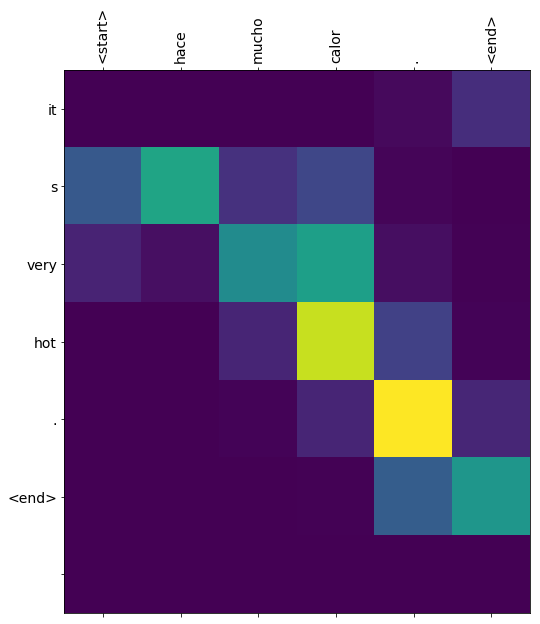

In [26]:
translate('hace mucho calor.', encoder, decoder, inp_lang, targ_lang, max_length_inp, max_length_targ)

Input: <start> hace mucho calor . <end>
Predicted translation: it s very hot . <end> 


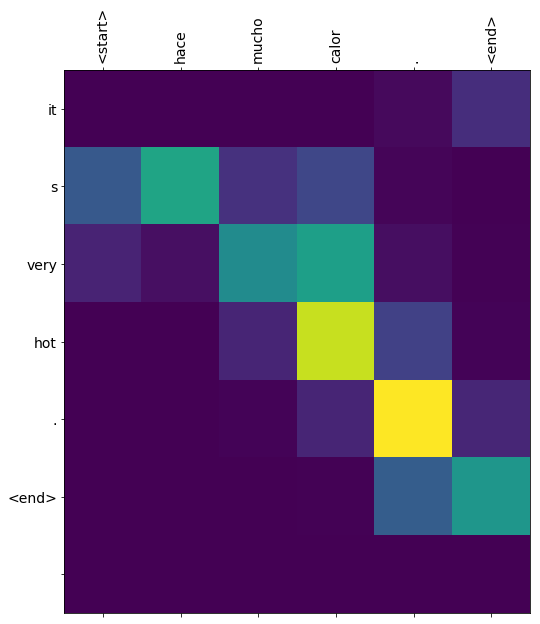

In [27]:
translate('hace mucho calor.', encoder, decoder, inp_lang, targ_lang, max_length_inp, max_length_targ)

Input: <start> esta es mi vida . <end>
Predicted translation: this is my life . <end> 


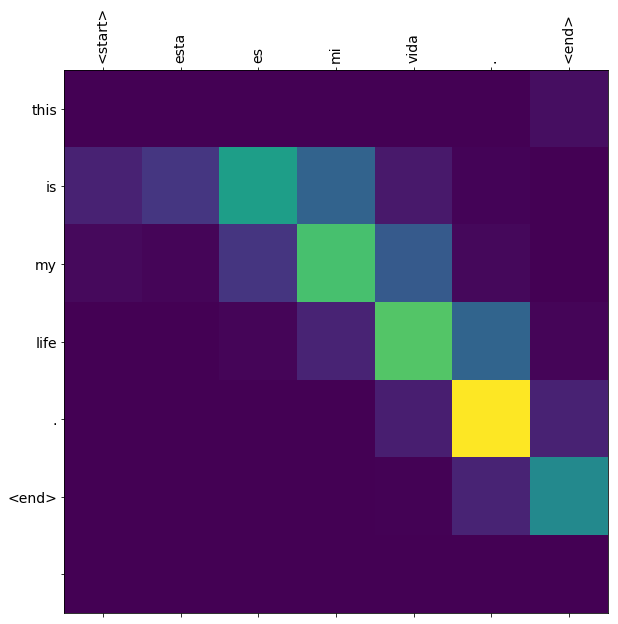

In [28]:
translate('esta es mi vida.', encoder, decoder, inp_lang, targ_lang, max_length_inp, max_length_targ)

Input: <start> ¿ cual es tu nombre ? <end>
Predicted translation: what s your name ? <end> 


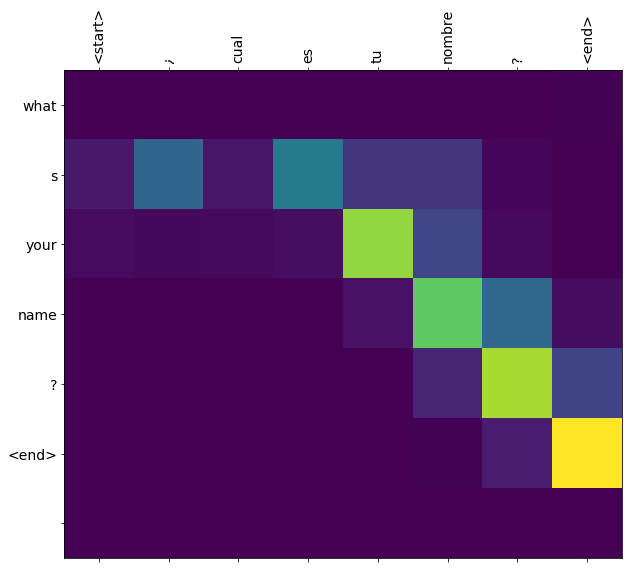

In [29]:
translate('¿cual es tu nombre?', encoder, decoder, inp_lang, targ_lang, max_length_inp, max_length_targ)

Input: <start> mira al cielo . <end>
Predicted translation: look at the sky . <end> 


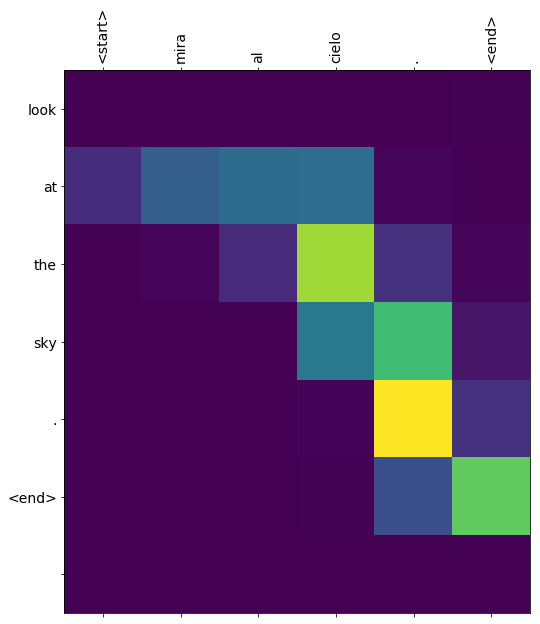

In [30]:
translate('mira al cielo.', encoder, decoder, inp_lang, targ_lang, max_length_inp, max_length_targ)

Input: <start> ¿ sabes si esta mal ? <end>
Predicted translation: do you know that s wrong ? <end> 


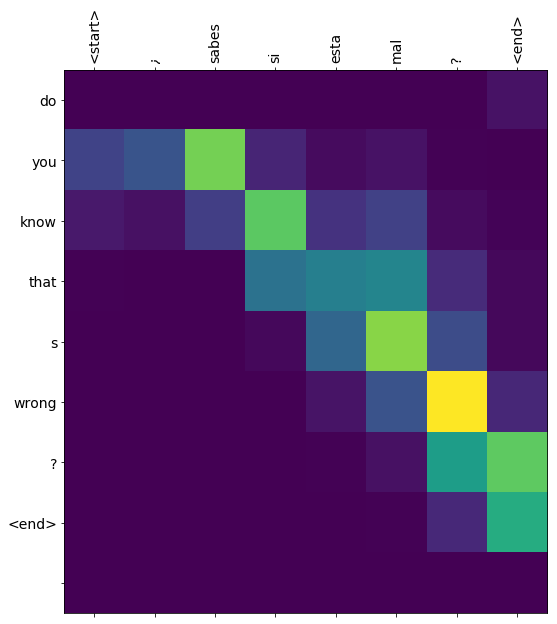

In [33]:
translate('¿Sabes si está mal?', encoder, decoder, inp_lang, targ_lang, max_length_inp, max_length_targ)